# Variational Inference API Quickstart

PyMC4 now comes integrated with tensorflow probability to use Variational Inference approximations.

- Mean Field ADVI - Implemented
- Full Rank ADVI - Coming Soon
- Low Rank ADVI - Coming Soon

For a more exhaustic introduction to VI, checkout this [blog post](https://www.codingpaths.com/gsoc/variational-inference/).

In [1]:
import pymc4 as pm
import numpy as np
import arviz as az
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from pprint import pprint

plt.style.use('arviz-darkgrid')

Let's infer $\mu$ and $\sigma$ for Normal Distribution

In [2]:
# Generating data
MU = 12
SIGMA = 2.2
data = np.random.normal(MU, SIGMA, 200)

In [3]:
@pm.model
def model():
    mu = yield pm.Normal('mu', 0, 10)
    sigma = yield pm.Exponential('sigma', 1)
    ll = yield pm.Normal('ll', mu, sigma, observed=data)
    return ll

In [4]:
approx_model = model()

In [5]:
help(pm.fit)

Help on function fit in module pymc4.variational.approximations:

fit(model: Union[pymc4.coroutine_model.Model, NoneType] = None, method: Union[str, pymc4.variational.approximations.MeanField] = 'advi', num_steps: int = 10000, sample_size: int = 1, random_seed: Union[int, NoneType] = None, optimizer=None, **kwargs)
    Fit an approximating distribution to log_prob of the model.
    
    Parameters
    ----------
    model : Optional[:class:`Model`]
        Model to fit posterior against
    method : Union[str, :class:`Approximation`]
        Method to fit model using VI
    
        - 'advi' for :class:`MeanField`
        - 'fullrank_advi' for :class:`FullRank`
        - 'lowrank_advi' for :class:`LowRank`
        - or directly pass in :class:`Approximation` instance
    num_steps : int
        Number of iterations to run the optimizer
    sample_size : int
        Number of Monte Carlo samples used for approximation
    random_seed : Optional[int]
        Seed for tensorflow random nu

In [6]:
mean_field = pm.fit(approx_model, num_steps=40000)

Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


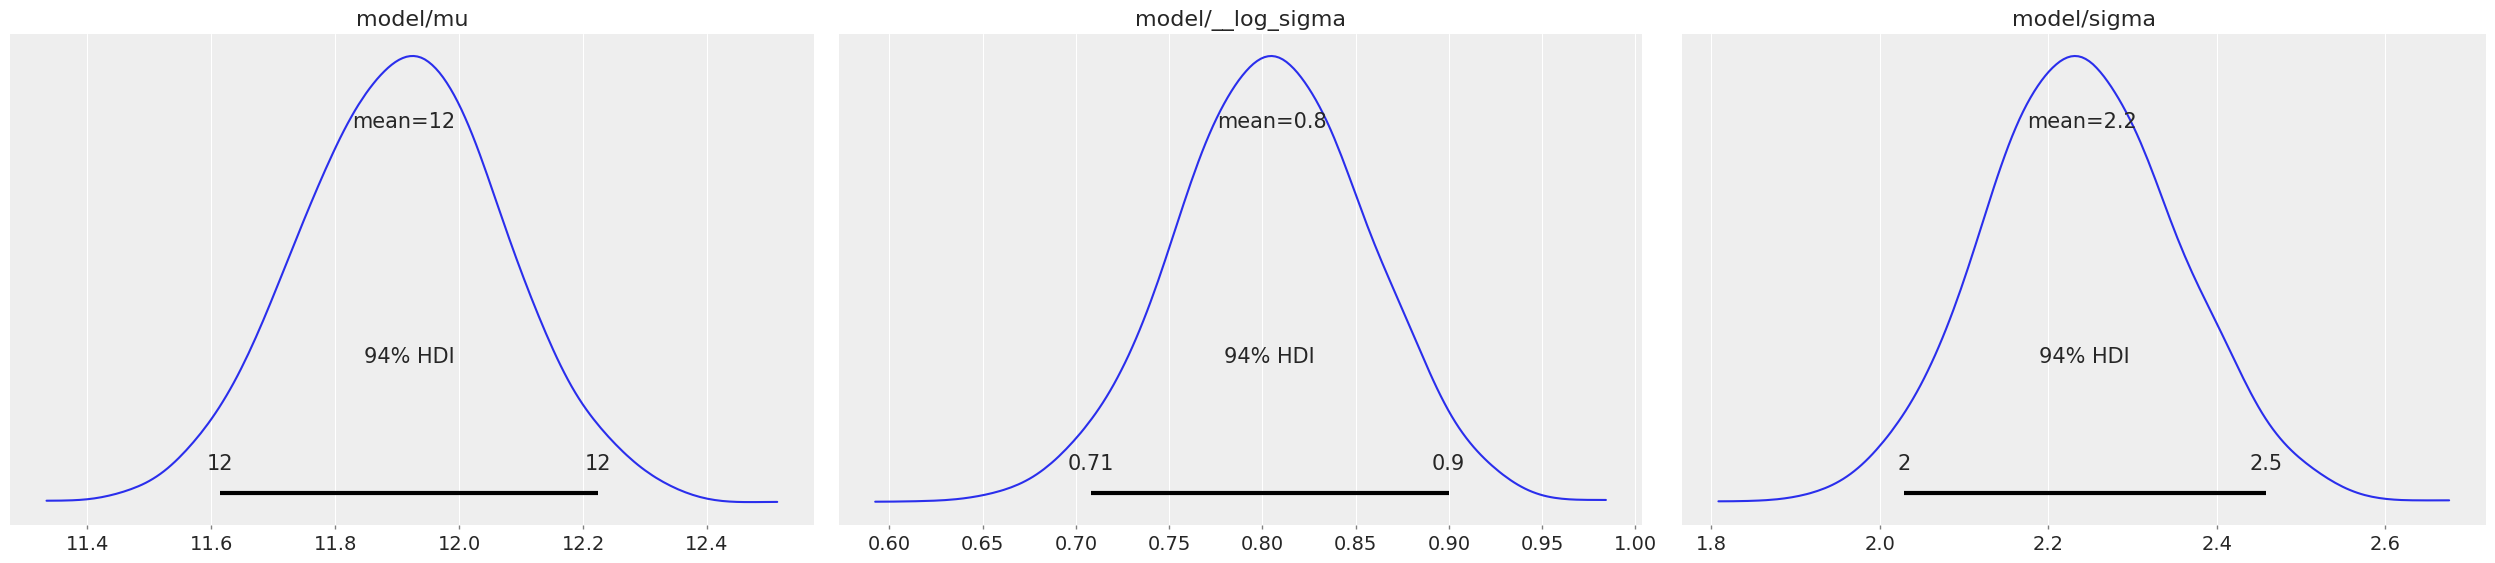

In [7]:
az.plot_posterior(mean_field.approximation.sample(5000));

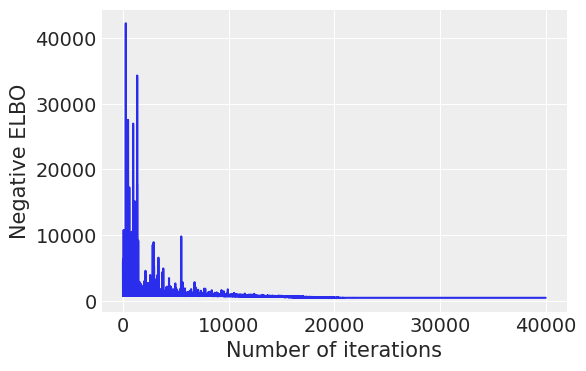

In [8]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, xlabel='Number of iterations', ylabel='Negative ELBO')
ax.plot(mean_field.losses)
# ax.set_yscale("log");

ELBO seems to have converged.

## Parameter Tracking

This is similar to `callbacks` in PyMC3.

In [9]:
approx_model = model()
advi = pm.MeanField(approx_model)

In [10]:
# Useful for NUTS sampling
pprint([
    advi.approx.mean(),
    advi.approx.stddev()
])

[[<tf.Tensor: shape=(), dtype=float32, numpy=-1.1033962>,
  <tf.Tensor: shape=(), dtype=float32, numpy=-0.6438769>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0>]]


In [11]:
advi.trainable_variables
# advi.approx.shared_params in PyMC3

(<tf.Variable 'model/mu/mu:0' shape=() dtype=float32, numpy=-1.1033962>,
 <tf.Variable 'model/mu/sigma:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'model/__log_sigma/mu:0' shape=() dtype=float32, numpy=-0.6438769>,
 <tf.Variable 'model/__log_sigma/sigma:0' shape=() dtype=float32, numpy=0.54132485>)

Recall for Mean Field ADVI, we approximate each parameter by Gaussian Distribution in unbounded space.

In [12]:
# track dict
track = dict()
for param in advi.trainable_variables:
    track[param.name] = param

In [13]:
# Let's build a trace function
def trace_fn(traceable_quantities):
    return {'loss': traceable_quantities.loss, **track}

In [14]:
mean_field = pm.fit(num_steps=40000, method=advi, trace_fn=trace_fn)

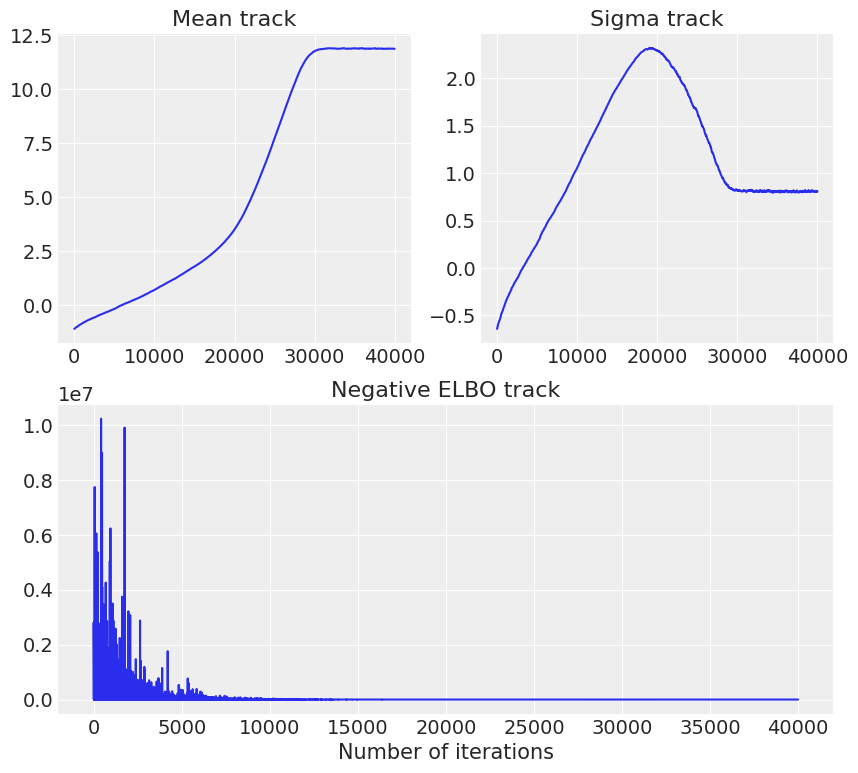

In [15]:
approximated_mu = mean_field.losses['model/mu/mu:0']
approximated_sigma = mean_field.losses['model/__log_sigma/mu:0']
loss = mean_field.losses['loss']

fig = plt.figure(figsize=(10, 9))
mu_track = fig.add_subplot(221)
sigma_track = fig.add_subplot(222)
elbo_track = fig.add_subplot(212)

mu_track.plot(approximated_mu)
mu_track.set_title('Mean track')
sigma_track.plot(approximated_sigma)
sigma_track.set_title('Sigma track')
elbo_track.plot(loss)
elbo_track.set_title('Negative ELBO track')
elbo_track.set_xlabel('Number of iterations');

In [16]:
advi.trainable_variables

(<tf.Variable 'model/mu/mu:0' shape=() dtype=float32, numpy=11.874878>,
 <tf.Variable 'model/mu/sigma:0' shape=() dtype=float32, numpy=-1.7840238>,
 <tf.Variable 'model/__log_sigma/mu:0' shape=() dtype=float32, numpy=0.81213427>,
 <tf.Variable 'model/__log_sigma/sigma:0' shape=() dtype=float32, numpy=-2.953592>)

We got pretty close estimates to $\mu$ and $\sigma$. Also, the parameter $\sigma$ needs to transformed via exp and that will be close to 2.2

### TODO - Add a convergence_criterion example

In [17]:
%load_ext watermark

In [18]:
%watermark -v -m --iversions

numpy                  1.18.5
tensorflow_probability 0.11.0-dev20200619
pymc4                  4.0a2
seaborn                0.10.1
tensorflow             2.3.0-dev20200616
arviz                  0.8.3
CPython 3.7.7
IPython 7.15.0

compiler   : Clang 11.0.0 (clang-1100.0.33.17)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
